<a href="https://colab.research.google.com/github/stprior/explore-transformer/blob/main/attribution-gpt-neo-125b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The goal of this notebook is to show how the output of a particular transformer vector depends on earlier positions and lower layers. My initial understanding is that the attention sublayer directly depends on earlier positions in the same layer (and indirectly on earlier positions in lower layers) and that the NN sublayer depends directly on the same position in lower layers (and indirectly on the earlier positions in lower layers.
I am taking the lowest layer to be the one taking input, and the highest layer generating output. 

## Acknowledgements

Based on ideas from nostalgebraist in [Interpreting Gpt the Logit Lens](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens) and Jay Allamar in [Ecco](https://github.com/jalammar/ecco), and built using [Hugging Face Transformers](https://huggingface.co/transformers/), [EleutherAI gpt-neo](interpreting-gpt-the-logit-lens), [Captum](https://captum.ai/) and https://github.com/nostalgebraist/transformer-utils
 


# Setup


## Packages

In [1]:
%pip install transformer_utils
%pip install captum

     |████████████████████████████████| 2.6 MB 4.9 MB/s 
     |████████████████████████████████| 895 kB 41.2 MB/s 
     |████████████████████████████████| 3.3 MB 14.7 MB/s 
     |████████████████████████████████| 636 kB 33.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.4 MB 4.3 MB/s 


## Load Model

In [2]:
from transformer_utils.low_memory import enable_low_memory_load
import transformers

enable_low_memory_load()
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125M')

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [3]:
import torch

def text_to_input_ids(text):
    toks = tokenizer.encode(text)
    return torch.as_tensor(toks).view(1, -1).cuda()

# Exploration


## Basics

In [4]:
text = "The forecast said that thunderstorm activity with the risk of hail will lead to localised"
tokens = text_to_input_ids(text)
tokens, tokens.shape, tokenizer.batch_decode(tokens[0][-4:])

(tensor([[  464, 11092,   531,   326, 18355, 12135,  3842,   351,   262,  2526,
            286, 32405,   481,  1085,   284,  1957,  1417]], device='cuda:0'),
 torch.Size([1, 17]),
 [' lead', ' to', ' local', 'ised'])

In [5]:
result = model.forward(tokens)

In [6]:
result.logits.shape

torch.Size([1, 17, 50257])

For each of the 17 positions, the Laguage Model makes a prediction of likelihood of each of the 50257 possible tokens being the next one. This graph shows an apparent trend, probably explained by earlier tokens being the more commonly used.

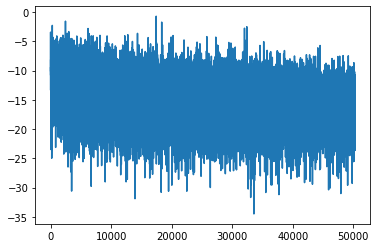

In [7]:
import matplotlib.pyplot as plt
plt.plot(result.logits[0,16].cpu().detach().numpy())

Argmax gives the reasonable prediction of 'flooding' in the last position.

In [8]:
predicted = torch.argmax(result.logits[0,16])
predicted, tokenizer.decode(predicted), result.logits[0,16,predicted]

(tensor(17448, device='cuda:0'),
 ' flooding',
 tensor(-0.7156, device='cuda:0', grad_fn=<SelectBackward>))

## Embedding Vectors

Bypassing language modelling so we can work directly with the transformer vectors, first confirm we get the same result:

In [9]:
embeds = model.transformer.wte(tokens)
transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
type(transformer_outputs)

transformers.modeling_outputs.BaseModelOutputWithPast

In [10]:
transformer_outputs.last_hidden_state.shape


torch.Size([1, 17, 768])

In [11]:
def show_prediction(transformer_outputs,posn):
  output_vec = transformer_outputs.last_hidden_state[0,posn]
  t_logits = model.lm_head(output_vec)
  t_predicted = torch.argmax(t_logits)
  print(t_predicted, tokenizer.decode(t_predicted), t_logits[t_predicted])

show_prediction(transformer_outputs,16)

tensor(17448, device='cuda:0')  flooding tensor(-0.7156, device='cuda:0', grad_fn=<SelectBackward>)


## Plot Embedding Vector Waveforms

This compares the embedding vector generated from the input token to that output by the top layer, predicting the next token.

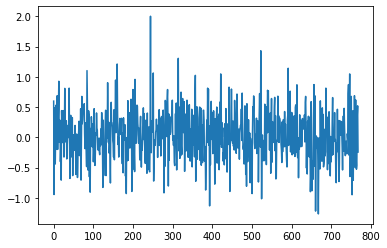

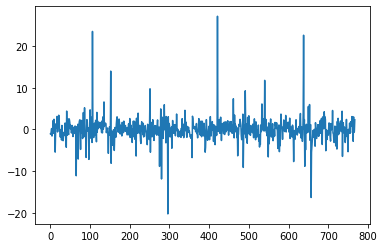

In [32]:
output_vec=transformer_outputs.last_hidden_state[0,16]
plt.plot(embeds[0,16].cpu().detach().numpy())
plt.show()
plt.plot(output_vec.cpu().detach().numpy())
plt.show()

# Attribution

## Attribute a specific logit output to embedding vector inputs

Now we can define a custom modified forward function which we can use for attribution for a specific output word vector. 
The model is wrapped in a function to allow transformer.forward be called with the inputs_embeds argument rather than default first arg, and to return the relevant logit as a single record 1d-tensor.

In [14]:

def make_forward_with_embeds(target_position, target_tokenid):
    
  def forward_with_embeds(embeds):
      
      transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
      output_vec = transformer_outputs.last_hidden_state[0,target_position]
      lm_logits = model.lm_head(output_vec)
      return lm_logits[target_tokenid:target_tokenid+1] #captum expects
    
  return forward_with_embeds

Test again (expect -0.7156)

In [15]:
make_forward_with_embeds( 16, 17448 )(embeds)

tensor([-0.7156], device='cuda:0', grad_fn=<SliceBackward>)

Using the [Integrated Gradients](https://arxiv.org/pdf/1703.01365.pdf) algorithm through [Captum](https://captum.ai/docs/extension/integrated_gradients) we use 
attribution to identify what part of the embedding inputs are most important to the logit for the expected output term (flooding).

In [16]:
from captum.attr import IntegratedGradients
def attribute(attributor):
  embeds = model.transformer.wte(tokens)
  embeds.requires_grad_()
  return attributor.attribute(embeds)

attr = attribute(IntegratedGradients(make_forward_with_embeds( 16, 17448 )))


### Input Position Salience

Using norm on each vector in the input and plotting against the corresponding label gives a plausible interpretation of the importance of each term.

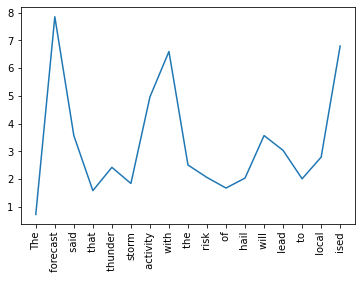

In [17]:
import numpy as np

def show_posn_salience(attribution):
  norms = np.linalg.norm(attribution.cpu().detach().numpy(), axis=1)
  labels = [tokenizer.decode(token) for token in tokens[0]]

  fig, ax = plt.subplots()
  ax.plot(norms)
  ax.set_xticks(np.arange(attribution.shape[0]))

  ax.set_xticklabels(labels,rotation='vertical')
  plt.show()

show_posn_salience(attr[0])

### Attribution to a single embedding vector
This shows attribution against the last token vector.

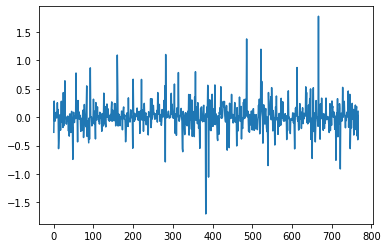

In [18]:
plt.plot(attr[0,16].cpu().detach().numpy())

## Attribute specific logit excess to embedding vector inputs

The previous wrapper of the forward method would identify inputs as significant even if they increased logits for other symbols more than the target one. The version below outputs the difference between the target logit and the mean of all logits. Further investigation is required to see if this is helpful or not.

In [19]:
def make_logit_less_mean_embeds(target_position, target_tokenid):
    
  def logit_less_mean_embeds(embeds):
      
      transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
      output_vec = transformer_outputs.last_hidden_state[0,target_position]
      lm_logits = model.lm_head(output_vec)
      logits_mean = torch.mean(lm_logits)
      return lm_logits[target_tokenid:target_tokenid+1] -logits_mean
    
  return logit_less_mean_embeds

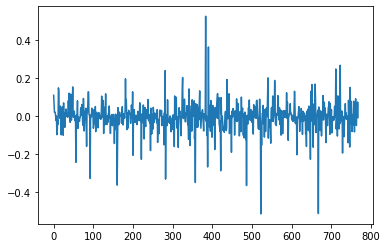

In [20]:

attr = attribute(IntegratedGradients(make_logit_less_mean_embeds( 16, 17448 )))

plt.plot(attr[0,16].cpu().detach().numpy())

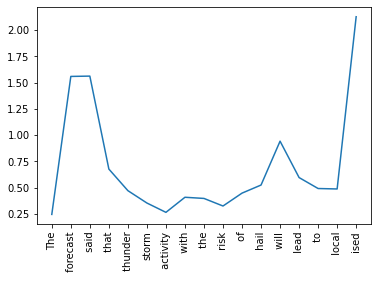

In [21]:

show_posn_salience(attr[0])

Results are similar but fewer positions are higlighted.

## Verify vector attribution

Attempt to verify that the attribution makes some sense, first by zeroing out the elements with the lowest attribution.

In [22]:
def drop_low_salience(level, abs_attrib=True, posn=16):
  embeds = model.transformer.wte(tokens)
  attr = ig.attribute(embeds)
  attribv = torch.abs(attr[0,posn]) if abs_attrib else attr[0,posn]
  mask = attribv.ge(level)
  drop_masked(embeds, mask)

def drop_masked(embeds, mask, posn=16):
  embeds = model.transformer.wte(tokens)
  original = torch.clone(embeds[0,posn])
  fake = torch.where(mask, original,torch.zeros_like(original))
  embeds[0,posn]=fake
  transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
  output_vec = transformer_outputs.last_hidden_state[0,posn]
  t_logits = model.lm_head(output_vec)
  t_predicted = torch.argmax(t_logits)
  print(f'Kept {torch.count_nonzero(fake)} of {torch.count_nonzero(original)} nonzero elements')

  transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
  output_vec = transformer_outputs.last_hidden_state[0,posn]
  t_logits = model.lm_head(output_vec)
  t_predicted = torch.argmax(t_logits)
  print(f'Predicted token {t_predicted} "{tokenizer.decode(t_predicted)}" logit value: {t_logits[t_predicted]}')



### Drop Low Salience Elements

In [23]:
ig = IntegratedGradients(make_logit_less_mean_embeds( 16, 17448 ))
drop_low_salience(0.005)
drop_low_salience(0.003)
drop_low_salience(0.002)
drop_low_salience(0.001)



Kept 651 of 768 nonzero elements
Predicted token 9725 " roads" logit value: -3.4601097106933594
Kept 681 of 768 nonzero elements
Predicted token 1956 " land" logit value: -3.5059995651245117
Kept 718 of 768 nonzero elements
Predicted token 32405 " hail" logit value: -1.159827709197998
Kept 737 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: 0.6034069061279297


In [24]:
ig = IntegratedGradients(make_forward_with_embeds( 16, 17448 ))

drop_low_salience(0.01)
drop_low_salience(0.008)
drop_low_salience(0.005)
drop_low_salience(0.003)


Kept 661 of 768 nonzero elements
Predicted token 35 "D" logit value: -4.676674842834473
Kept 683 of 768 nonzero elements
Predicted token 3705 "PS" logit value: -6.548995494842529
Kept 711 of 768 nonzero elements
Predicted token 2766 " leaders" logit value: -4.026045799255371
Kept 732 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: -1.5533447265625


### Drop Random Elements

Compare this to randomly dropping a similar number of elements

In [25]:
def drop_random(rate):
  embeds = model.transformer.wte(tokens)
  mask = torch.rand(embeds[0,0].shape, device=embeds.device).ge(rate) 
  drop_masked(embeds, mask)

drop_random(31/768)
drop_random(20/768)
drop_random(10/768)
drop_random(5/768)
drop_random(1/768)



Kept 732 of 768 nonzero elements
Predicted token 16512 " closure" logit value: -3.924337387084961
Kept 751 of 768 nonzero elements
Predicted token 1630 " control" logit value: 0.4560842514038086
Kept 761 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: -1.3447051048278809
Kept 766 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: -0.9458942413330078
Kept 767 of 768 nonzero elements
Predicted token 17448 " flooding" logit value: -0.5045576095581055


###Drop Highly Salient Elements

Inverting this, how many high salience tokens do we need to drop to affect the predicted token.

In [26]:
def drop_high_salience(level, abs_attrib=True):
  embeds = model.transformer.wte(tokens)
  attr = ig.attribute(embeds)
  attribv = torch.abs(attr[0,16]) if abs_attrib else attr[0,16]
  mask = attribv.le(level)
  drop_masked(embeds, mask)

drop_high_salience(0.1)
drop_high_salience(0.2)
drop_high_salience(0.4)
drop_high_salience(0.4, False)

Kept 437 of 768 nonzero elements
Predicted token 447 "�" logit value: -18.380136489868164
Kept 585 of 768 nonzero elements
Predicted token 447 "�" logit value: -22.18278694152832
Kept 706 of 768 nonzero elements
Predicted token 366 " "" logit value: -26.003774642944336
Kept 731 of 768 nonzero elements
Predicted token 564 " �" logit value: -24.0369873046875


### Result 

Integrated Gradients seems to correctly identify important dimensions in the input embedding vector.

Dropping low salience vector elements results in conceptually similar output tokens, and approx 30 can be dropped. Dropping 1 high salient element changes the output.


Next, repeat with other tokens. Check the input token in different positions...

In [27]:
print(tokens[0,13], tokenizer.decode(tokens[0,13]))
print(tokens[0,14], tokenizer.decode(tokens[0,14]))
print(tokens[0,15], tokenizer.decode(tokens[0,15]))
print(tokens[0,16], tokenizer.decode(tokens[0,16]))

tensor(1085, device='cuda:0')  lead
tensor(284, device='cuda:0')  to
tensor(1957, device='cuda:0')  local
tensor(1417, device='cuda:0') ised


And the predicted tokens.

In [28]:
embeds = model.transformer.wte(tokens)
transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
show_prediction(transformer_outputs,13)
show_prediction(transformer_outputs,14)
show_prediction(transformer_outputs,15)

tensor(284, device='cuda:0')  to tensor(0.5942, device='cuda:0', grad_fn=<SelectBackward>)
tensor(257, device='cuda:0')  a tensor(-0.9616, device='cuda:0', grad_fn=<SelectBackward>)
tensor(290, device='cuda:0')  and tensor(-0.9020, device='cuda:0', grad_fn=<SelectBackward>)


First look at input 'lead' predicting token 'to'.
Surprisingly this appears to depend little on the previous token, possibly suggesting a mistake in the calculation or interpretation. A less likely possiblity is that 'to' is a grammatical word and so depends on the overall sentence structure or frame rather than the specific previous word. As expected masking prevents any influence from the last input tokens.

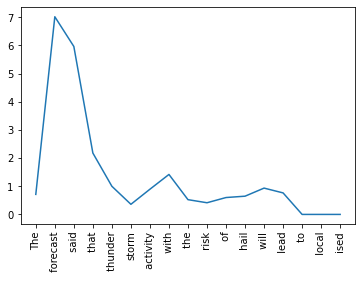

In [34]:
attr = attribute(IntegratedGradients(make_logit_less_mean_embeds(13,284)))
show_posn_salience(attr[0])

The other tokens look similer.  I see no obvious explanation or interpretation of these.

'to' -> 'a'

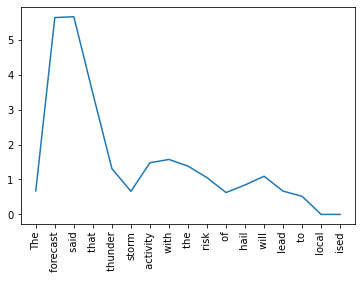

In [35]:
attr = attribute(IntegratedGradients(make_logit_less_mean_embeds(14,257)))
show_posn_salience(attr[0])

'local' -> 

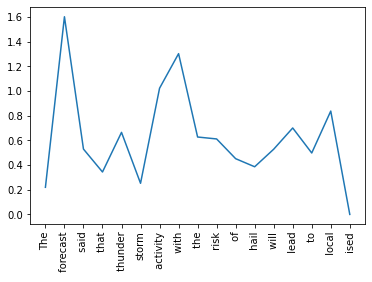

In [37]:
attr = attribute(IntegratedGradients(make_logit_less_mean_embeds(15,290)))
show_posn_salience(attr[0])